In [346]:
import cv2

In [2]:
%load_ext autoreload
# %autoreload 2

In [3]:
%autoreload 2
from reconstruct import get_from_mat, correct_image, iradon_centered, find_visual_best

In [93]:
! ls /home/amaevskiy/Tomo/tomography/data/Sino_Igor/2018_11004450_hnee23_pappel_tensionWood_002/sino_phase_rawBin2/ -a

.		   sino_000193.tif  sino_000388.tif  sino_000583.tif
..		   sino_000194.tif  sino_000389.tif  sino_000584.tif
._sino_000313.tif  sino_000195.tif  sino_000390.tif  sino_000585.tif
sino_000001.tif    sino_000196.tif  sino_000391.tif  sino_000586.tif
sino_000002.tif    sino_000197.tif  sino_000392.tif  sino_000587.tif
sino_000003.tif    sino_000198.tif  sino_000393.tif  sino_000588.tif
sino_000004.tif    sino_000199.tif  sino_000394.tif  sino_000589.tif
sino_000005.tif    sino_000200.tif  sino_000395.tif  sino_000590.tif
sino_000006.tif    sino_000201.tif  sino_000396.tif  sino_000591.tif
sino_000007.tif    sino_000202.tif  sino_000397.tif  sino_000592.tif
sino_000008.tif    sino_000203.tif  sino_000398.tif  sino_000593.tif
sino_000009.tif    sino_000204.tif  sino_000399.tif  sino_000594.tif
sino_000010.tif    sino_000205.tif  sino_000400.tif  sino_000595.tif
sino_000011.tif    sino_000206.tif  sino_000401.tif  sino_000596.tif
sino_000012.tif    sino_000207.tif  sino_000402.tif  sino_0

In [7]:
! cat /home/amaevskiy/Tomo/tomography/data/Sino_Igor/2018_11004450_hnee23_pappel_tensionWood_002/reco_phase_tie_regPar1p50_rawBin2.log

scan_name : hnee23_pappel_tensionWood_002
beamtime_id : 11004450
scan_path : /asap3/petra3/gpfs/p05/2018/data/11004450/raw/hnee23_pappel_tensionWood_002/
reco_path : /asap3/petra3/gpfs/p05/2018/data/11004450/processed/hnee23_pappel_tensionWood_002/for_russia/reco_phase/tie_regPar1p50/
MATLAB notation, index of first element: 1, range: first:stride:last
MATLAB version : 9.4.0.813654 (R2018a)
Git commit ID : 212e8e42572bfe1c705a9a3784545e1c8aaf0bb7
platform : GLNXA64
effective_pixel_size : 1.28032 micron
effective_pixel_size_binned : 2.56064 micron
energy : 31031.7 eV
sample_detector_distance : 0.609989 m
camera : KIT
exposure_time : 100.000000
num_dark_found : 10
num_ref_found : 130
num_ref_used : 123
ref_range : 1:1:130
num_proj_found : 1201
num_proj_used : 1179
proj_range : 1:1:1201
im_shape_raw : 5120 3840
raw_roi :  1460 3010
im_shape_roi : 5120 1551
im_shape_binned : 2560 775
im_shape_cropbin1 : 2461 raw_binning_factor : 2
ring_current_normalization : 1
image_correlation.method : s

In [17]:
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def get_tiffs_from_folder(path='../data/2018_11005553_syn033_68R_Mg10Gd_12w/sino_rawBin2'):
    tiffs = []
    for tiff_file in tqdm(sorted([os.path.join(path, file) for file in os.listdir(path) if file.startswith('sino')])):
        tiffs.append(np.array(Image.open(tiff_file)))
    return np.array(tiffs)

In [94]:
tiffs = get_tiffs_from_folder(path='/home/amaevskiy/Tomo/tomography/data/Sino_Igor/2018_11004450_hnee23_pappel_tensionWood_002/sino_phase_rawBin2')

100%|██████████| 775/775 [01:28<00:00,  8.72it/s]


In [95]:
tiffs.shape

(775, 1179, 2461)

In [96]:
angles = np.linspace(0, 1.998335 * np.pi, tiffs.shape[1])[None, :]

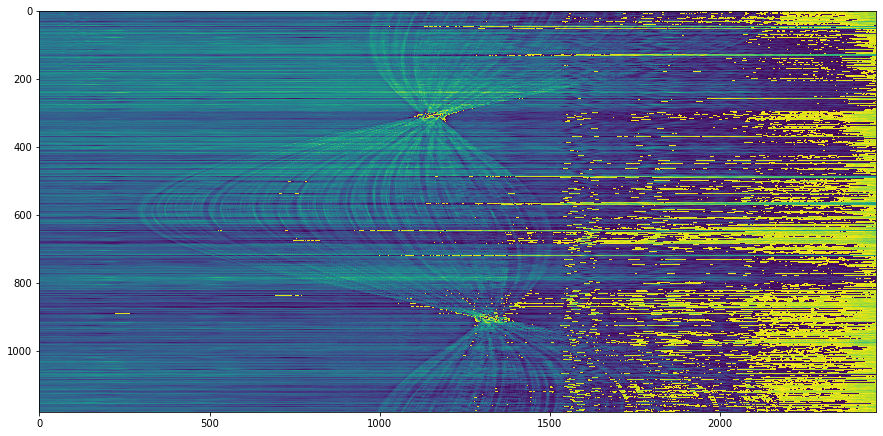

In [97]:
plt.figure(figsize=(15, 20))
plt.imshow(convert2uint8(tiffs[-1]))
# plt.imsave()

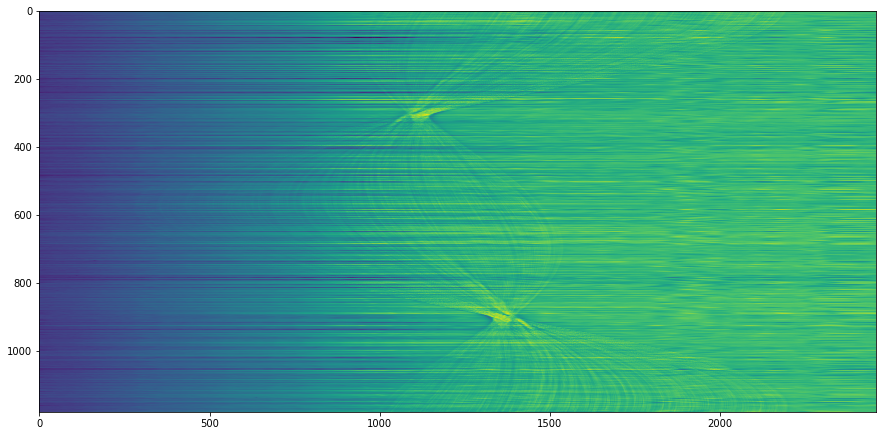

In [98]:
plt.figure(figsize=(15, 20))
plt.imshow(tiffs[1])

## Take need axes

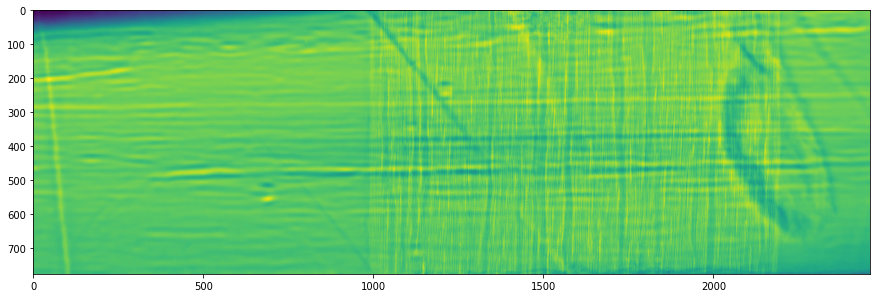

In [99]:
plt.figure(figsize=(15, 20))
plt.imshow(tiffs[:,0, :])
# plt.imsave('left.png', tiffs[:,0, :])

In [100]:
np.where(angles.squeeze() * 180 / np.pi >= 180)[0][0]

590

In [110]:
(angles.squeeze() * 180 / np.pi)[590]

180.15549830220712

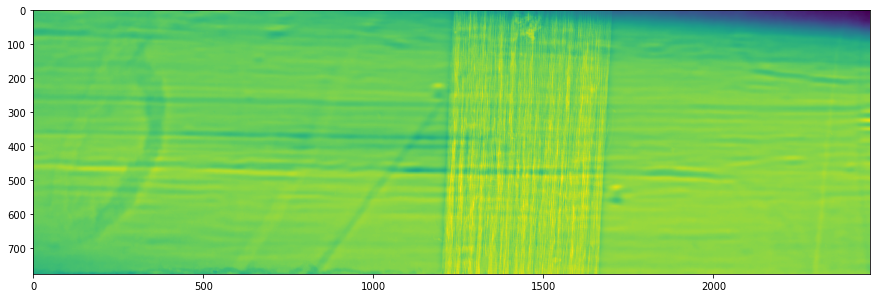

In [102]:
plt.figure(figsize=(15, 20))
plt.imshow(tiffs[:,376, ::-1])
# plt.imsave('right.png',tiffs[:,376, ::-1])

Если сравнить как раз кажется виден этот нужный сдвиг!

In [103]:
# TBD:

def convert2uint8(img):
    return ((img - img.min()) / img.max() * 255).astype('uint8')

In [104]:
i = 5

In [105]:
left = convert2uint8(tiffs[:,0+i, :])
right = convert2uint8(tiffs[:,376+i, ::-1])

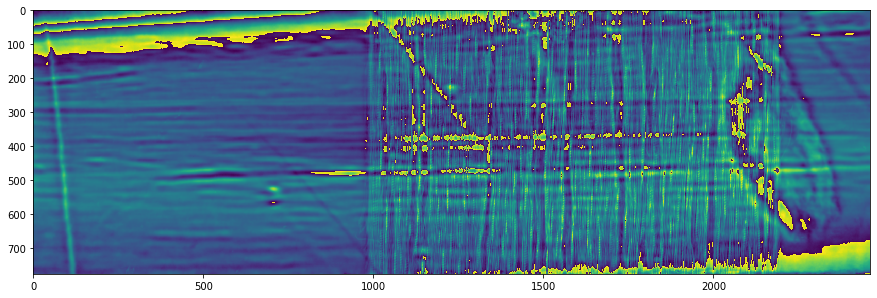

In [106]:
plt.figure(figsize=(15, 20))
plt.imshow(left)
# plt.imsave('left.png', left)

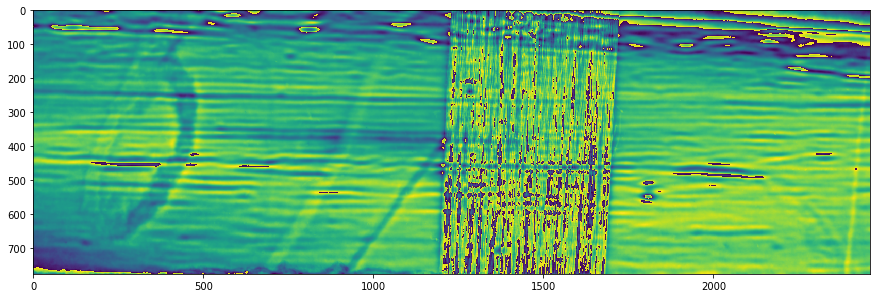

In [107]:
plt.figure(figsize=(15, 20))
plt.imshow(right)
# plt.imsave('right.png', right)

## Find minimal sums over availble shift axes (it works!)

In [108]:
from scipy.interpolate import InterpolatedUnivariateSpline

In [109]:
def find_with_mse(left, right, shift = 15, use_pad=False, use_spline_minima=True, loss='l2', ignore_percent=0):
    best_id = 0
    temp_sum_arr = []
    for i in range(-shift, shift):
        if use_pad:
            if i < 0:
                left_temp = np.hstack([np.full((left.shape[0], abs(i)), left.mean()), left[:, :-abs(i)]])
            else:
                left_temp = np.hstack([left[:, abs(i):], np.full((left.shape[0], abs(i)), left.mean())])
        else:
            left_temp = left[:,i + shift:i - shift].copy()
        right_temp = right[:, shift:-shift].copy()
        if ignore_percent > 0:
            right_temp[:, int(right_temp.shape[1] / 2 * (1 - ignore_percent / 2)):int(right_temp.shape[1] / 2 * (ignore_percent / 2 + 1))] = 0
            left_temp[:, int(left_temp.shape[1] / 2 * (1 - ignore_percent / 2)):int(left_temp.shape[1] / 2 * (ignore_percent / 2 + 1))] = 0
        if loss == 'l2':
            temp_sum = (np.square(right_temp - left_temp)).mean()
        else:
            temp_sum = (np.abs(right_temp - left_temp)).mean()
        temp_sum_arr.append(temp_sum)
    if use_spline_minima:
        x_axis = np.arange(-shift, shift)
        f = InterpolatedUnivariateSpline(x_axis, np.array(temp_sum_arr), k=4)
        cr_pts = f.derivative().roots()
        cr_pts = np.append(cr_pts, (x_axis[0], x_axis[-1]))  # also check the endpoints of the interval
        cr_vals = f(cr_pts)
        min_index = np.argmin(cr_vals)
        max_index = np.argmax(cr_vals)
#         print(cr_pts, cr_vals)
        min_point = cr_pts[min_index]
    else:
        min_point = np.argmin(temp_sum_arr) - shift
    return min_point, np.array(temp_sum_arr)

## Sanity check

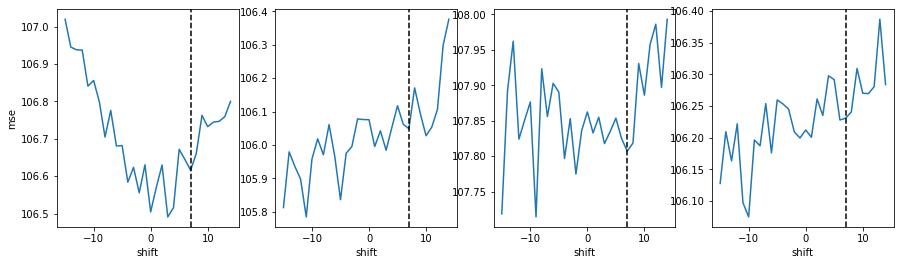

In [111]:
shift = 15
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
ids = []
for ax_id, i in enumerate(range(0, 20, 5)):
    ax = axs[ax_id]
    left = convert2uint8(tiffs[:,0+i, :])
    right = convert2uint8(tiffs[:,590+i, ::-1])
    best_id, temp_sum_arr = find_with_mse(left, right, shift)
    ids.append(best_id)
    ax.plot(np.arange(-shift, shift), temp_sum_arr)
    if ax_id == 0:
        ax.set_ylabel('mse')
    ax.axvline(x=3.5 * 2, color='k', linestyle='--')
    ax.set_xlabel('shift')

In [112]:
np.array(ids) / 2

array([ 1.70430957, -5.52842908, -4.53474475, -5.20341912])

In [ ]:
converted_angles = angles.squeeze() * 180 / np.pi

## Run massive tests with a best fitted - no normalization

In [268]:
shift = 30
predictions = []
for i in range(tiffs.shape[1]):
    left = tiffs[:,i, :]
    aligned_id = np.argmin(np.abs(converted_angles - 180 - converted_angles[i]))
#     print(i, aligned_id, converted_angles[aligned_id] - 180 - converted_angles[i])
    if np.abs(converted_angles[aligned_id] - 180 - converted_angles[i]) > 0.5:
        break
    right = tiffs[:,aligned_id, ::-1]
    best_id, temp_sum_arr = find_with_mse(left, right, shift)
    predictions.append(best_id)
predictions = np.array(predictions) / 2

In [269]:
filtered_mask = np.logical_and(predictions > np.quantile(predictions, 0.05), predictions < np.quantile(predictions, 0.95))
filtered = predictions[filtered_mask]

In [270]:
print('mean:', np.mean(filtered), 'standart error:', np.std(filtered) / np.sqrt(len(filtered)))

mean: 10.269943004372392 standart error: 0.07116513901839427


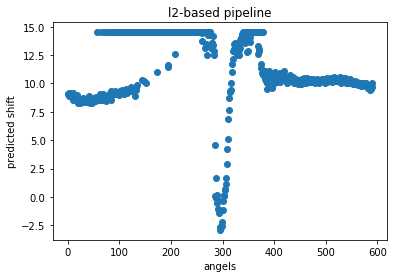

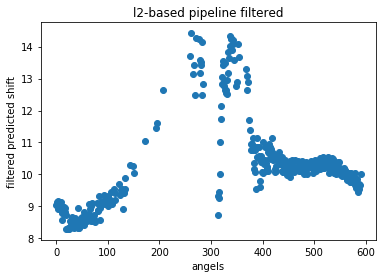

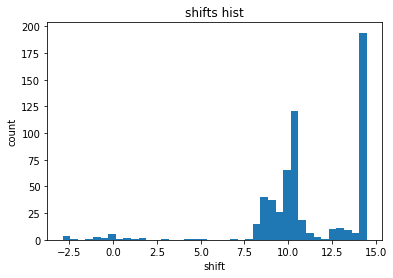

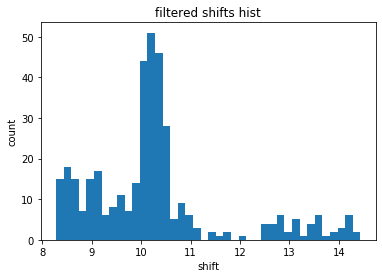

In [271]:
plt.scatter(np.arange(len(predictions)), predictions)
plt.xlabel('angels')
plt.ylabel('predicted shift')
plt.title('l2-based pipeline')
plt.show()

plt.scatter(np.arange(len(predictions))[filtered_mask], filtered)
plt.xlabel('angels')
plt.ylabel('filtered predicted shift')
plt.title('l2-based pipeline filtered')
plt.show()

plt.hist(predictions, bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('shifts hist')
plt.show()

plt.hist(predictions[filtered_mask], bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('filtered shifts hist')
plt.show()

## Run massive tests with a best fitted - normalized

In [272]:
shift = 30
predictions = []
for i in range(tiffs.shape[1]):
    left = convert2uint8(tiffs[:,i, :])
    aligned_id = np.argmin(np.abs(converted_angles - 180 - converted_angles[i]))
#     print(i, aligned_id, converted_angles[aligned_id] - 180 - converted_angles[i])
    if np.abs(converted_angles[aligned_id] - 180 - converted_angles[i]) > 0.5:
        break
    right = convert2uint8(tiffs[:,aligned_id, ::-1])
    best_id, temp_sum_arr = find_with_mse(left, right, shift)
    predictions.append(best_id)
predictions = np.array(predictions) / 2

In [273]:
filtered_mask = np.logical_and(predictions > np.quantile(predictions, 0.05), predictions < np.quantile(predictions, 0.95))
filtered = predictions[filtered_mask]

In [274]:
print('mean:', np.mean(filtered), 'standart error:', np.std(filtered) / np.sqrt(len(filtered)))

mean: 1.5688112569105974 standart error: 0.39271541915544866


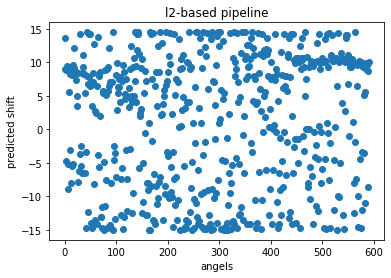

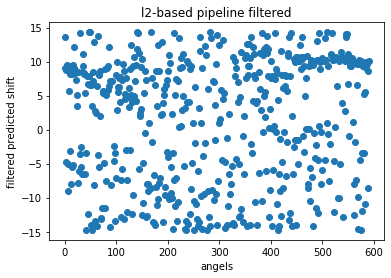

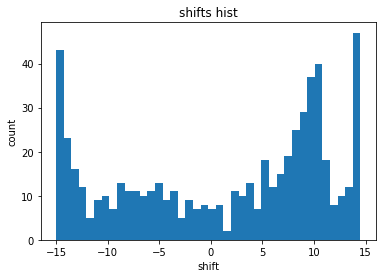

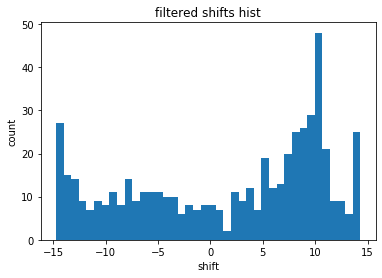

In [275]:
plt.scatter(np.arange(len(predictions)), predictions)
plt.xlabel('angels')
plt.ylabel('predicted shift')
plt.title('l2-based pipeline')
plt.show()

plt.scatter(np.arange(len(predictions))[filtered_mask], filtered)
plt.xlabel('angels')
plt.ylabel('filtered predicted shift')
plt.title('l2-based pipeline filtered')
plt.show()

plt.hist(predictions, bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('shifts hist')
plt.show()

plt.hist(predictions[filtered_mask], bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('filtered shifts hist')
plt.show()

## Quantile norm

In [349]:
def quantile_norm(img):
    return (img - np.quantile(img, 0.05)) / np.quantile(img, 0.95)

In [350]:
shift = 30
predictions = []
for i in range(tiffs.shape[1]):
    left = quantile_norm(tiffs[:,i, :])
    aligned_id = np.argmin(np.abs(converted_angles - 180 - converted_angles[i]))
#     print(i, aligned_id, converted_angles[aligned_id] - 180 - converted_angles[i])
    if np.abs(converted_angles[aligned_id] - 180 - converted_angles[i]) > 0.5:
        break
    right = quantile_norm(tiffs[:,aligned_id, ::-1])
    best_id, temp_sum_arr = find_with_mse(left, right, shift)
    predictions.append(best_id)
predictions = np.array(predictions) / 2

In [351]:
filtered_mask = np.logical_and(predictions > np.quantile(predictions, 0.05), predictions < np.quantile(predictions, 0.95))
filtered = predictions[filtered_mask]

In [352]:
print('mean:', np.mean(filtered), 'standart error:', np.std(filtered) / np.sqrt(len(filtered)))

mean: 10.230302625004033 standart error: 0.06825552174533826


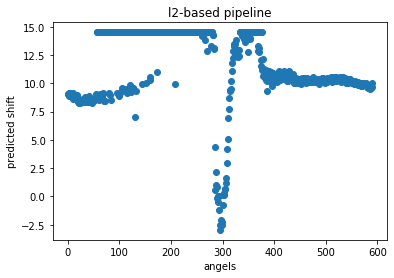

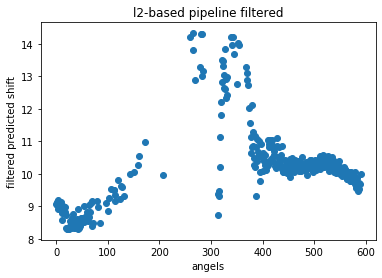

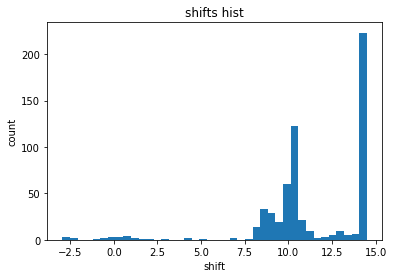

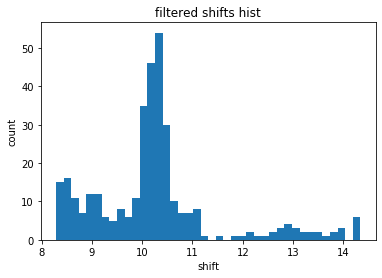

In [353]:
plt.scatter(np.arange(len(predictions)), predictions)
plt.xlabel('angels')
plt.ylabel('predicted shift')
plt.title('l2-based pipeline')
plt.show()

plt.scatter(np.arange(len(predictions))[filtered_mask], filtered)
plt.xlabel('angels')
plt.ylabel('filtered predicted shift')
plt.title('l2-based pipeline filtered')
plt.show()

plt.hist(predictions, bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('shifts hist')
plt.show()

plt.hist(predictions[filtered_mask], bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('filtered shifts hist')
plt.show()

## Std norm

In [354]:
def std_norm(img):
    return (img - np.mean(img)) / np.std(img)

In [355]:
shift = 30
predictions = []
for i in range(tiffs.shape[1]):
    left = std_norm(tiffs[:,i, :])
    aligned_id = np.argmin(np.abs(converted_angles - 180 - converted_angles[i]))
#     print(i, aligned_id, converted_angles[aligned_id] - 180 - converted_angles[i])
    if np.abs(converted_angles[aligned_id] - 180 - converted_angles[i]) > 0.5:
        break
    right = std_norm(tiffs[:,aligned_id, ::-1])
    best_id, temp_sum_arr = find_with_mse(left, right, shift)
    predictions.append(best_id)
predictions = np.array(predictions) / 2

In [356]:
filtered_mask = np.logical_and(predictions > np.quantile(predictions, 0.05), predictions < np.quantile(predictions, 0.95))
filtered = predictions[filtered_mask]

In [357]:
print('mean:', np.mean(filtered), 'standart error:', np.std(filtered) / np.sqrt(len(filtered)))

mean: 10.25770975410029 standart error: 0.07112752417355347


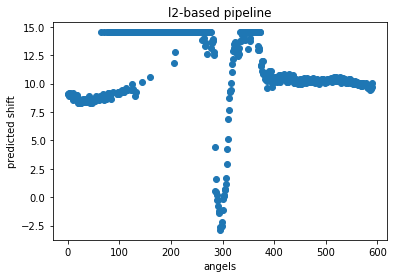

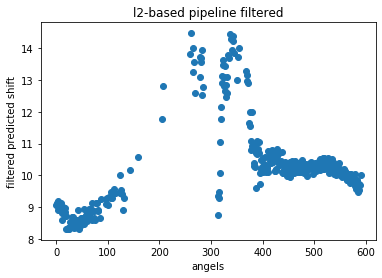

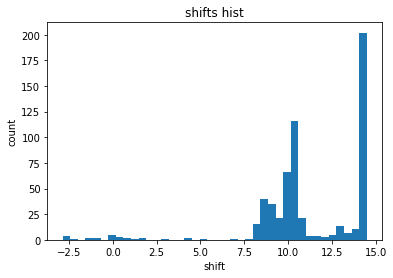

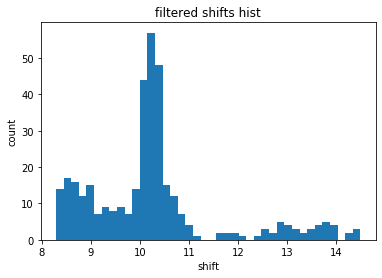

In [358]:
plt.scatter(np.arange(len(predictions)), predictions)
plt.xlabel('angels')
plt.ylabel('predicted shift')
plt.title('l2-based pipeline')
plt.show()

plt.scatter(np.arange(len(predictions))[filtered_mask], filtered)
plt.xlabel('angels')
plt.ylabel('filtered predicted shift')
plt.title('l2-based pipeline filtered')
plt.show()

plt.hist(predictions, bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('shifts hist')
plt.show()

plt.hist(predictions[filtered_mask], bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('filtered shifts hist')
plt.show()

## Ignore center of the image

In [292]:
shift = 30
predictions = []
for i in range(tiffs.shape[1]):
    left = tiffs[:,i, :]
    aligned_id = np.argmin(np.abs(converted_angles - 180 - converted_angles[i]))
#     print(i, aligned_id, converted_angles[aligned_id] - 180 - converted_angles[i])
    if np.abs(converted_angles[aligned_id] - 180 - converted_angles[i]) > 0.5:
        break
    right = tiffs[:,aligned_id, ::-1]
    best_id, temp_sum_arr = find_with_mse(left, right, shift, ignore_percent=0.3)
    predictions.append(best_id)
predictions = np.array(predictions) / 2

In [293]:
filtered_mask = np.logical_and(predictions > np.quantile(predictions, 0.05), predictions < np.quantile(predictions, 0.95))
filtered = predictions[filtered_mask]

In [294]:
print('mean:', np.mean(filtered), 'standart error:', np.std(filtered) / np.sqrt(len(filtered)))

mean: 9.499750282324047 standart error: 0.04841087523901732


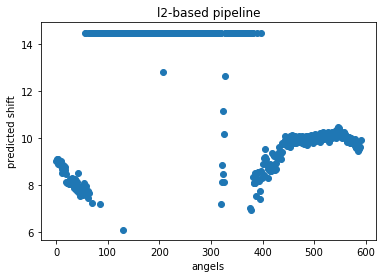

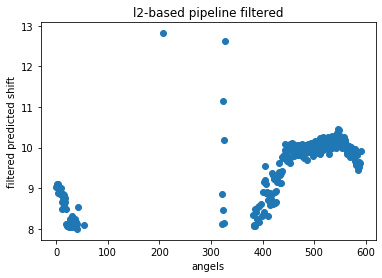

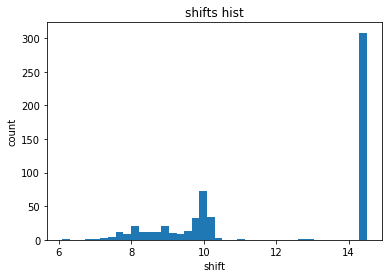

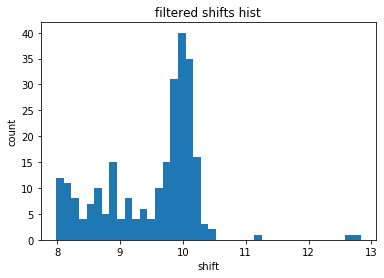

In [295]:
plt.scatter(np.arange(len(predictions)), predictions)
plt.xlabel('angels')
plt.ylabel('predicted shift')
plt.title('l2-based pipeline')
plt.show()

plt.scatter(np.arange(len(predictions))[filtered_mask], filtered)
plt.xlabel('angels')
plt.ylabel('filtered predicted shift')
plt.title('l2-based pipeline filtered')
plt.show()

plt.hist(predictions, bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('shifts hist')
plt.show()

plt.hist(predictions[filtered_mask], bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('filtered shifts hist')
plt.show()

## Higher percent

In [281]:
shift = 30
predictions = []
for i in range(tiffs.shape[1]):
    left = tiffs[:,i, :]
    aligned_id = np.argmin(np.abs(converted_angles - 180 - converted_angles[i]))
#     print(i, aligned_id, converted_angles[aligned_id] - 180 - converted_angles[i])
    if np.abs(converted_angles[aligned_id] - 180 - converted_angles[i]) > 0.5:
        break
    right = tiffs[:,aligned_id, ::-1]
    best_id, temp_sum_arr = find_with_mse(left, right, shift, ignore_percent=0.5)
    predictions.append(best_id)
predictions = np.array(predictions) / 2

In [282]:
filtered_mask = np.logical_and(predictions > np.quantile(predictions, 0.05), predictions < np.quantile(predictions, 0.95))
filtered = predictions[filtered_mask]

In [283]:
print('mean:', np.mean(filtered), 'standart error:', np.std(filtered) / np.sqrt(len(filtered)))

mean: 9.448871216723319 standart error: 0.051132938717073244


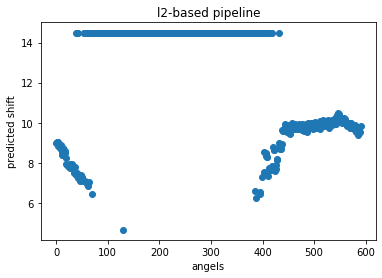

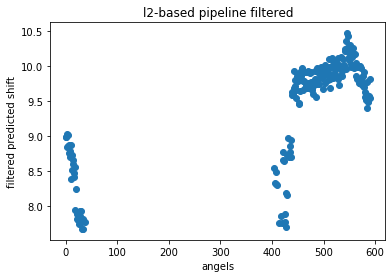

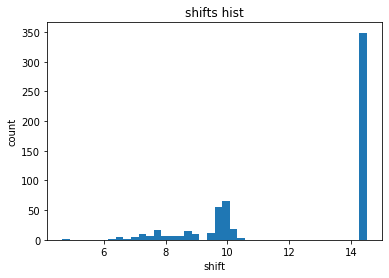

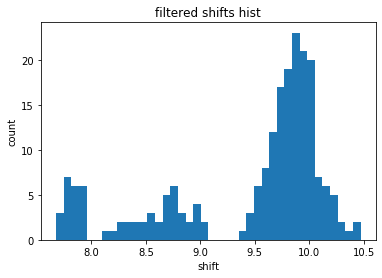

In [284]:
plt.scatter(np.arange(len(predictions)), predictions)
plt.xlabel('angels')
plt.ylabel('predicted shift')
plt.title('l2-based pipeline')
plt.show()

plt.scatter(np.arange(len(predictions))[filtered_mask], filtered)
plt.xlabel('angels')
plt.ylabel('filtered predicted shift')
plt.title('l2-based pipeline filtered')
plt.show()

plt.hist(predictions, bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('shifts hist')
plt.show()

plt.hist(predictions[filtered_mask], bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('filtered shifts hist')
plt.show()

## Lower percent

In [285]:
shift = 30
predictions = []
for i in range(tiffs.shape[1]):
    left = tiffs[:,i, :]
    aligned_id = np.argmin(np.abs(converted_angles - 180 - converted_angles[i]))
#     print(i, aligned_id, converted_angles[aligned_id] - 180 - converted_angles[i])
    if np.abs(converted_angles[aligned_id] - 180 - converted_angles[i]) > 0.5:
        break
    right = tiffs[:,aligned_id, ::-1]
    best_id, temp_sum_arr = find_with_mse(left, right, shift, ignore_percent=0.1)
    predictions.append(best_id)
predictions = np.array(predictions) / 2

In [286]:
filtered_mask = np.logical_and(predictions > np.quantile(predictions, 0.05), predictions < np.quantile(predictions, 0.95))
filtered = predictions[filtered_mask]

In [287]:
print('mean:', np.mean(filtered), 'standart error:', np.std(filtered) / np.sqrt(len(filtered)))

mean: 10.094744200352551 standart error: 0.0729083241711166


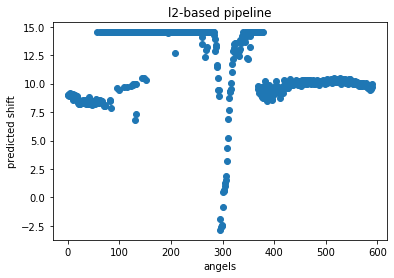

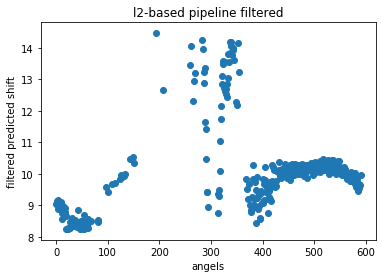

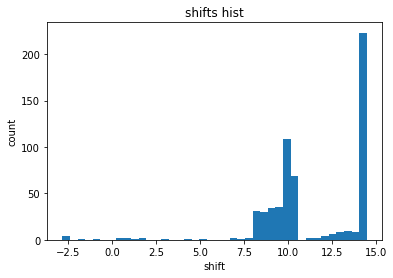

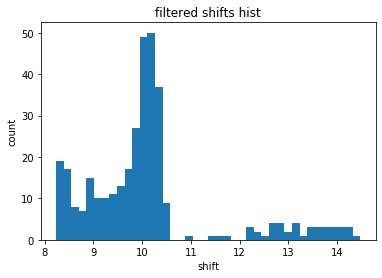

In [288]:
plt.scatter(np.arange(len(predictions)), predictions)
plt.xlabel('angels')
plt.ylabel('predicted shift')
plt.title('l2-based pipeline')
plt.show()

plt.scatter(np.arange(len(predictions))[filtered_mask], filtered)
plt.xlabel('angels')
plt.ylabel('filtered predicted shift')
plt.title('l2-based pipeline filtered')
plt.show()

plt.hist(predictions, bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('shifts hist')
plt.show()

plt.hist(predictions[filtered_mask], bins=40)
plt.xlabel('shift')
plt.ylabel('count')
plt.title('filtered shifts hist')
plt.show()

## Check with some recostructions

100%|██████████| 12/12 [26:50<00:00, 134.23s/it]


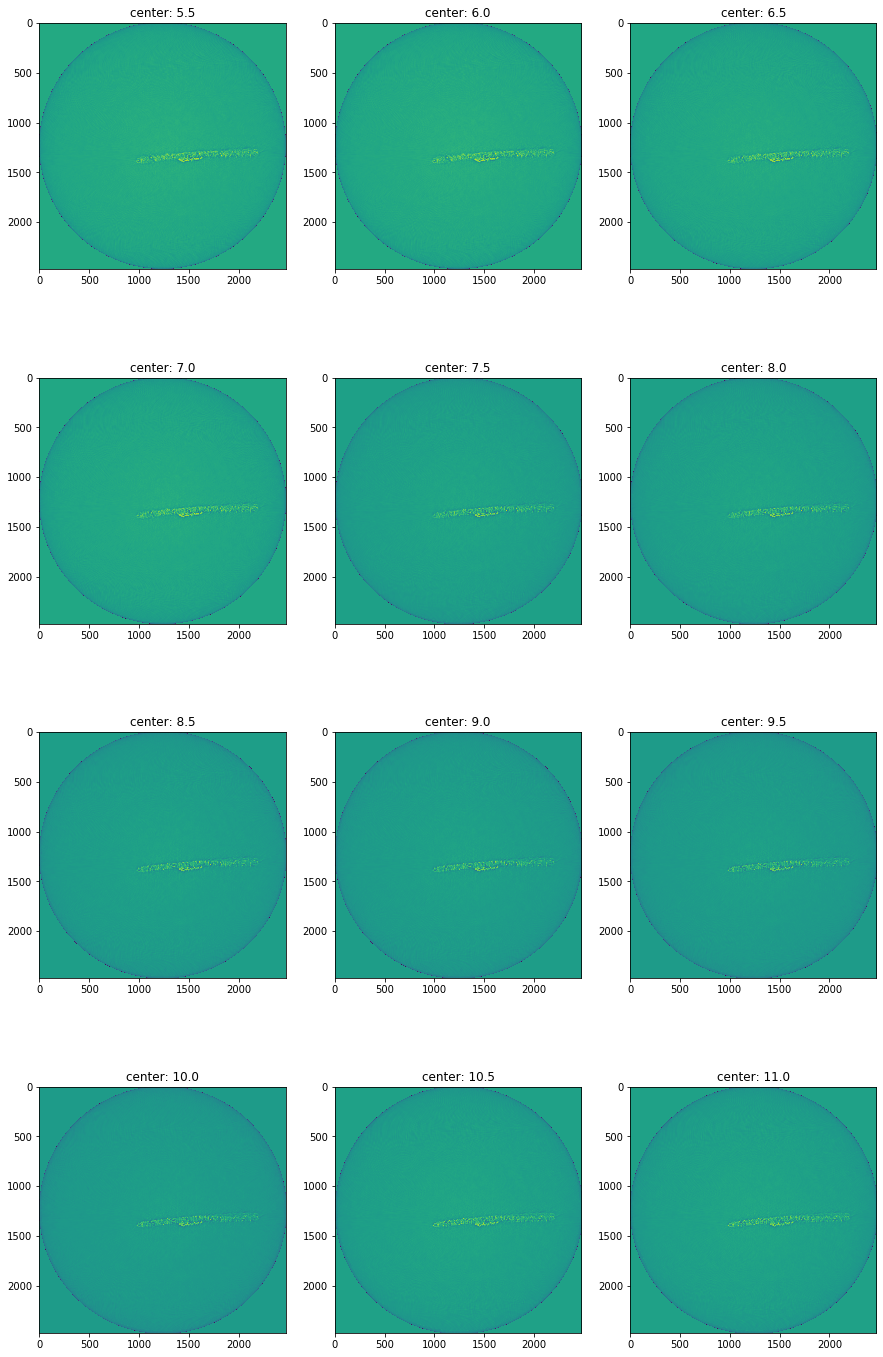

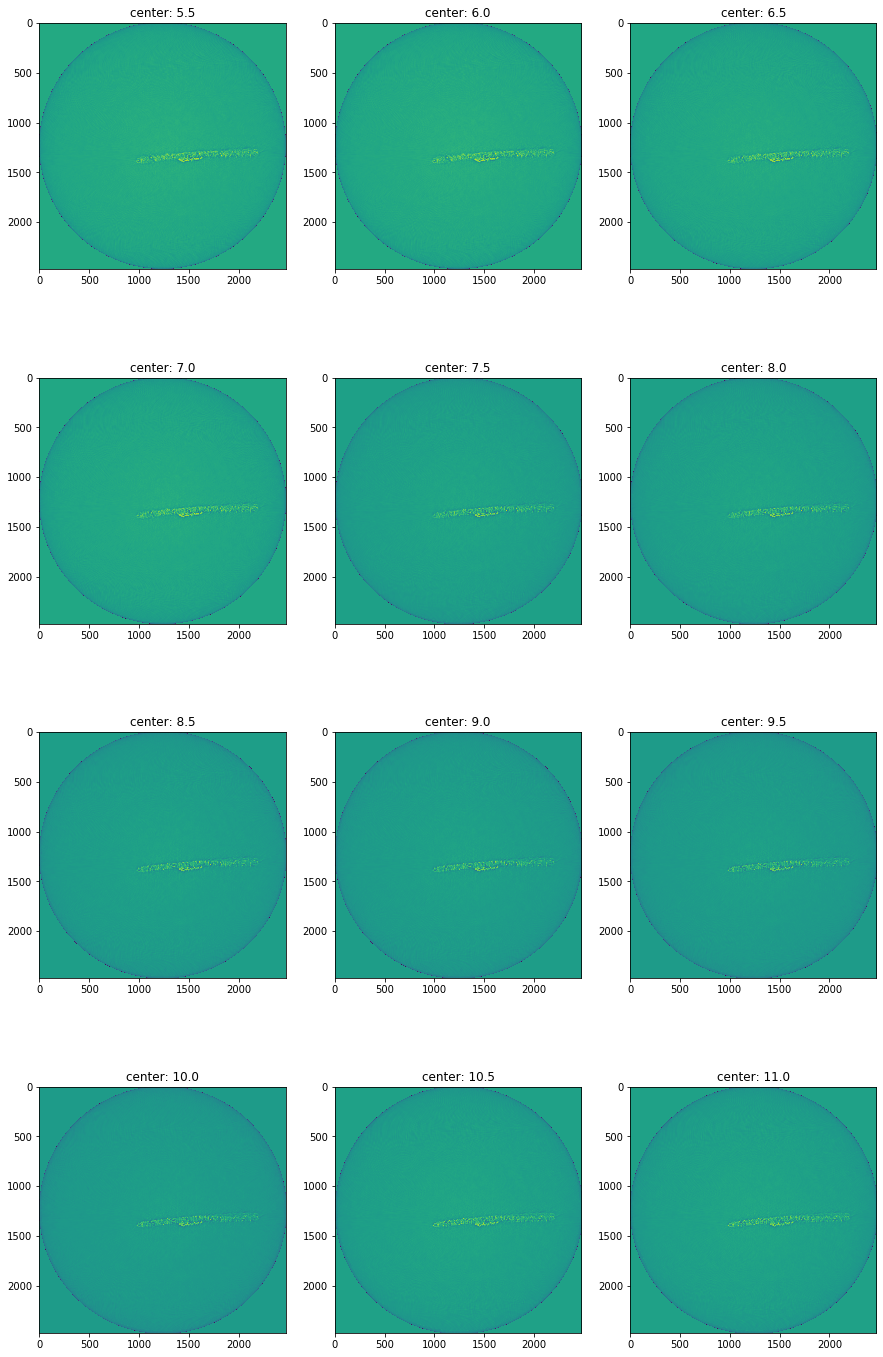

In [289]:
find_visual_best([5.5, 6., 6.5, 7., 7.5, 8., 8.5, 9., 9.5, 10., 10.5, 11.], tiffs[0, :, :], angles.squeeze(), ncols=3)
plt.show()

100%|██████████| 12/12 [27:54<00:00, 139.52s/it]


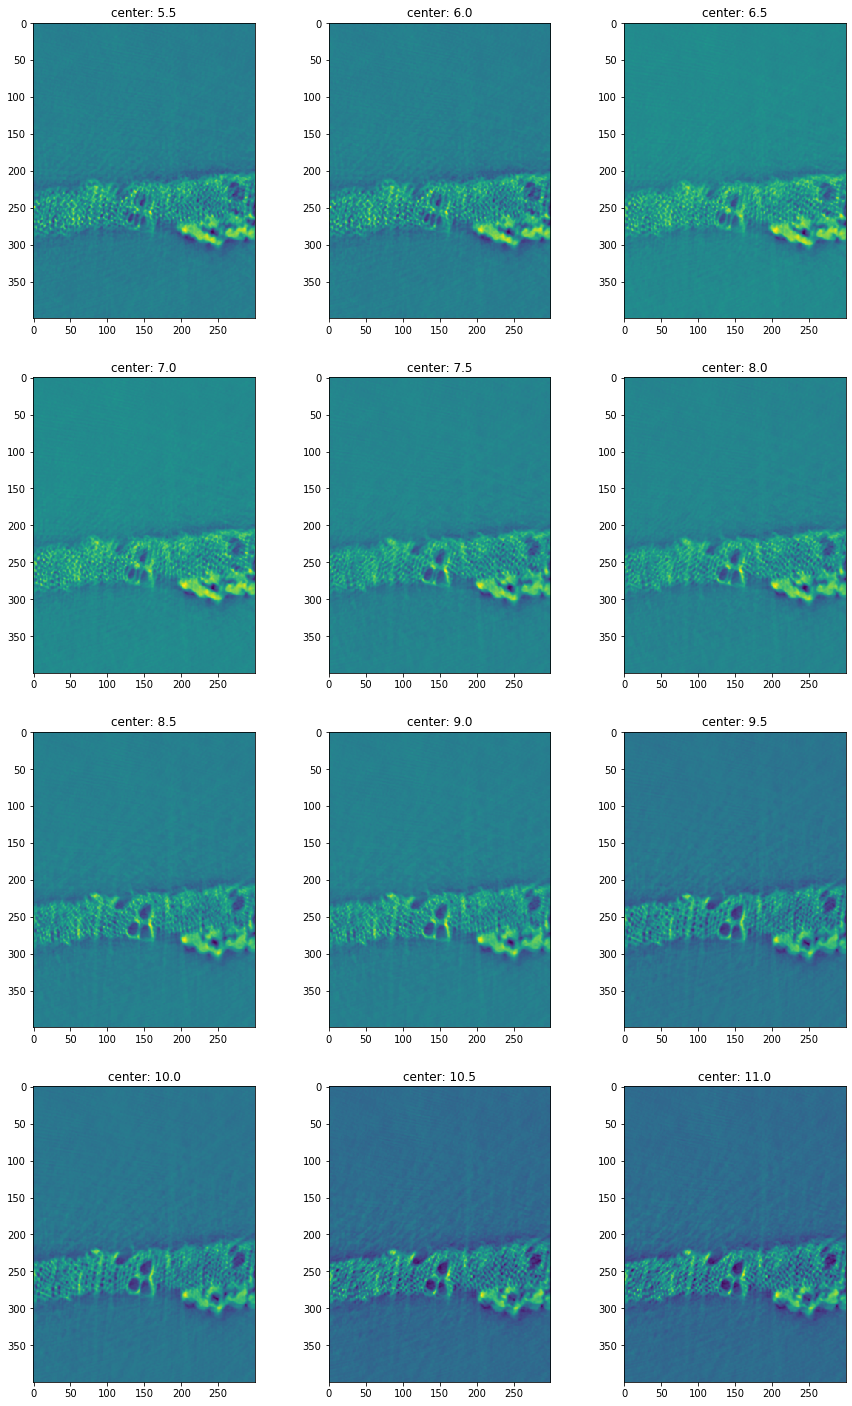

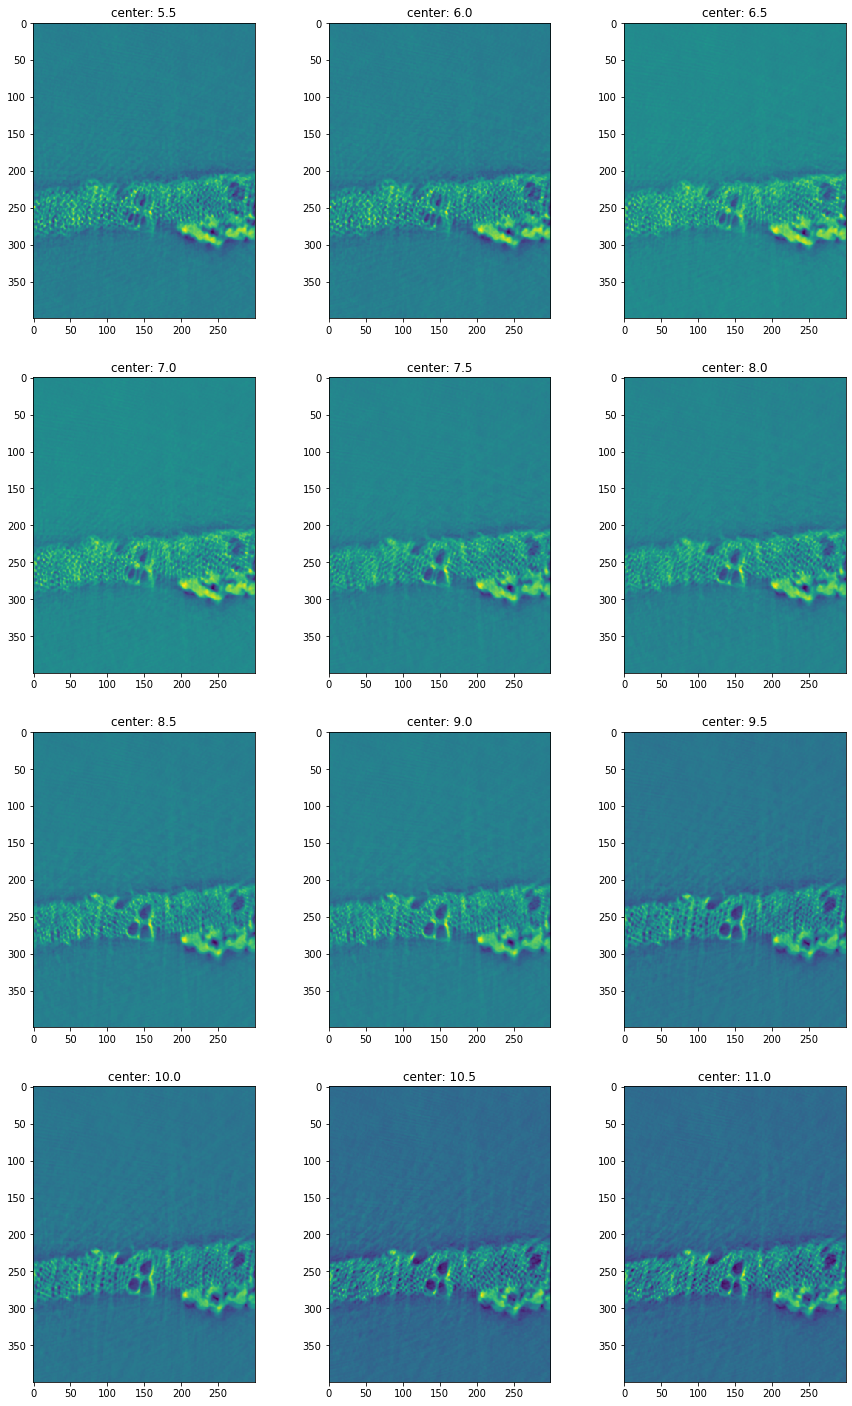

In [290]:
find_visual_best([5.5, 6., 6.5, 7., 7.5, 8., 8.5, 9., 9.5, 10., 10.5, 11.], tiffs[0, :, :], angles.squeeze(), ncols=3, from_x=1100, to_x=1500, from_y=1200, to_y=1500)
plt.show()

100%|██████████| 12/12 [26:47<00:00, 133.95s/it]


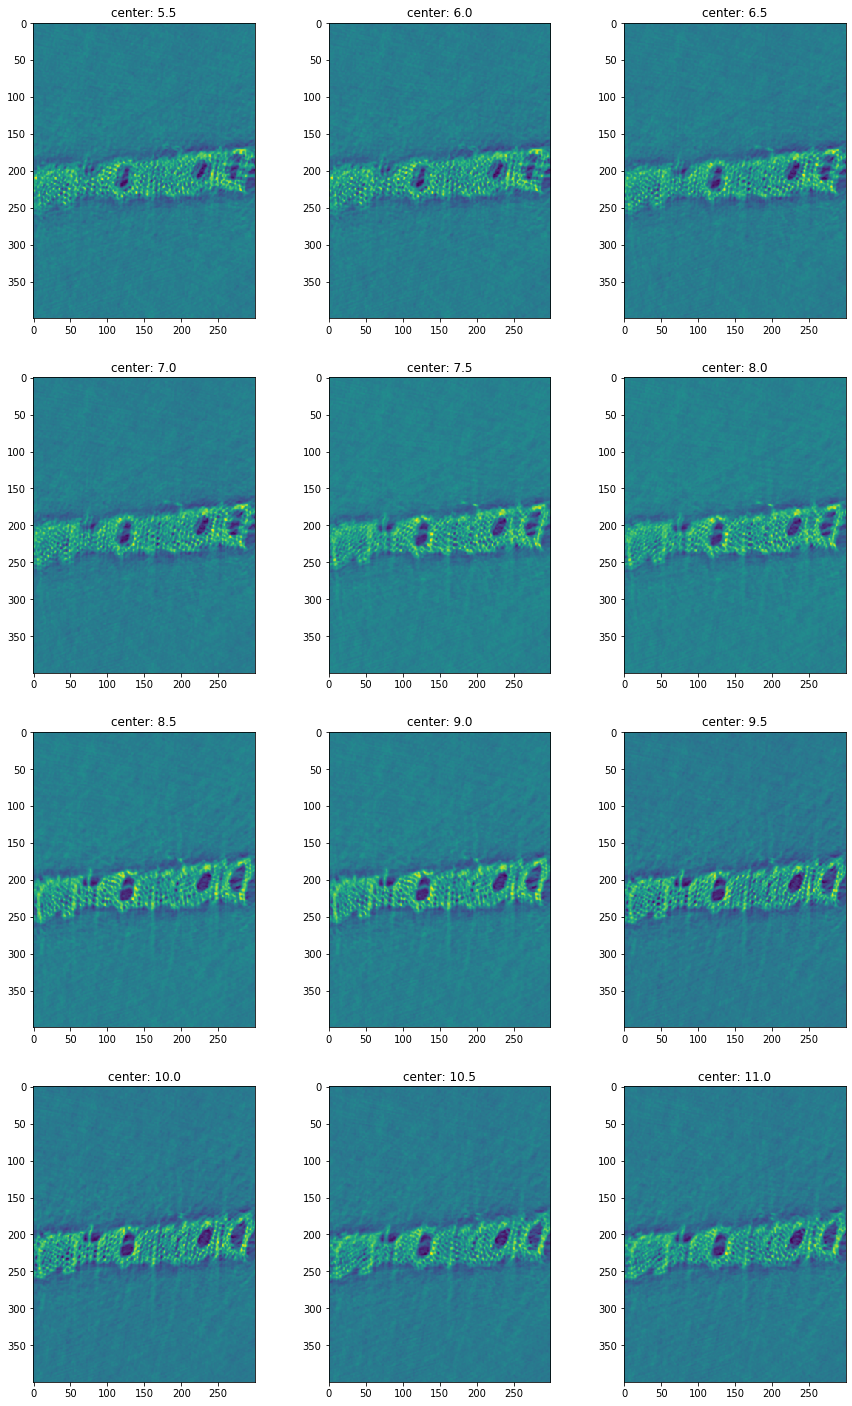

In [291]:
find_visual_best([5.5, 6., 6.5, 7., 7.5, 8., 8.5, 9., 9.5, 10., 10.5, 11.], tiffs[-1, :, :], angles.squeeze(), ncols=3, from_x=1100, to_x=1500, from_y=1200, to_y=1500)
plt.show()

## kakahi

In [296]:
# based on: https://github.com/scivision/pyoptflow/blob/master/pyoptflow/hornschunck.py

from scipy.ndimage.filters import convolve as filter2
import numpy as np
from typing import Tuple
#
HSKERN = np.array([[1/12, 1/6, 1/12],
                   [1/6,    0, 1/6],
                   [1/12, 1/6, 1/12]], float)

kernelX = np.array([[-1, 1],
                    [-1, 1]]) * .25  # kernel for computing d/dx

kernelY = np.array([[-1, -1],
                    [1, 1]]) * .25  # kernel for computing d/dy

kernelT = np.ones((2, 2))*.25


from matplotlib.pyplot import figure, draw, pause, gca
def plotderiv(fx, fy, ft):

    fg = figure(figsize=(18, 5))
    ax = fg.subplots(1, 3)

    for f, a, t in zip((fx, fy, ft), ax, ('$f_x$', '$f_y$', '$f_t$')):
        h = a.imshow(f, cmap='bwr')
        a.set_title(t)
        fg.colorbar(h, ax=a)


def HornSchunck(im1: np.ndarray, im2: np.ndarray, *,
                alpha: float = 0.001, Niter: int = 8,
                verbose: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    """
    Parameters
    ----------
    im1: numpy.ndarray
        image at t=0
    im2: numpy.ndarray
        image at t=1
    alpha: float
        regularization constant
    Niter: int
        number of iteration
    """
    im1 = im1.astype(np.float32)
    im2 = im2.astype(np.float32)

    # set up initial velocities
    uInitial = np.zeros([im1.shape[0], im1.shape[1]])
    vInitial = np.zeros([im1.shape[0], im1.shape[1]])

    # Set initial value for the flow vectors
    U = uInitial
    V = vInitial

    # Estimate derivatives
    [fx, fy, ft] = computeDerivatives(im1, im2)

    if verbose:
#         from .plots import plotderiv
        plotderiv(fx, fy, ft)

#    print(fx[100,100],fy[100,100],ft[100,100])

        # Iteration to reduce error
    for _ in range(Niter):
        # %% Compute local averages of the flow vectors
        uAvg = filter2(U, HSKERN)
        vAvg = filter2(V, HSKERN)
# %% common part of update step
        der = (fx*uAvg + fy*vAvg + ft) / (alpha**2 + fx**2 + fy**2)
# %% iterative step
        U = uAvg - fx * der #) + uInitial
        V = vAvg - fy * der #) + vInitial

    return U, V


def computeDerivatives(im1: np.ndarray, im2: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    fx = filter2(im1, kernelX) + filter2(im2, kernelX)
    fy = filter2(im1, kernelY) + filter2(im2, kernelY)

    # ft = im2 - im1
    ft = filter2(im1, kernelT) + filter2(im2, -kernelT)

    return fx, fy, ft

In [ ]:
x, y = HornSchunck(left, right, alpha=0.07)

In [ ]:
x.mean() * left.shape[1]

In [ ]:
plt.hist(np.clip(x.flatten() * left.shape[1], -30, 30), bins=40)
plt.show()

In [319]:
flow = np.empty((left.shape[0], left.shape[1], 2))
flow[..., 0] = x
flow[..., 1] = y

In [320]:
def draw_flow(img, flow, step=8):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fy, y+fx]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = img.copy()
#     vis = cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (x2, y2) in lines:
#         print(x1, y1, x2, y2)
        vis = cv2.arrowedLine(vis, (x1, y1), (x2, y2), np.random.randint(0,255,(1,3))[0].tolist(), 2)
#         vis = cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

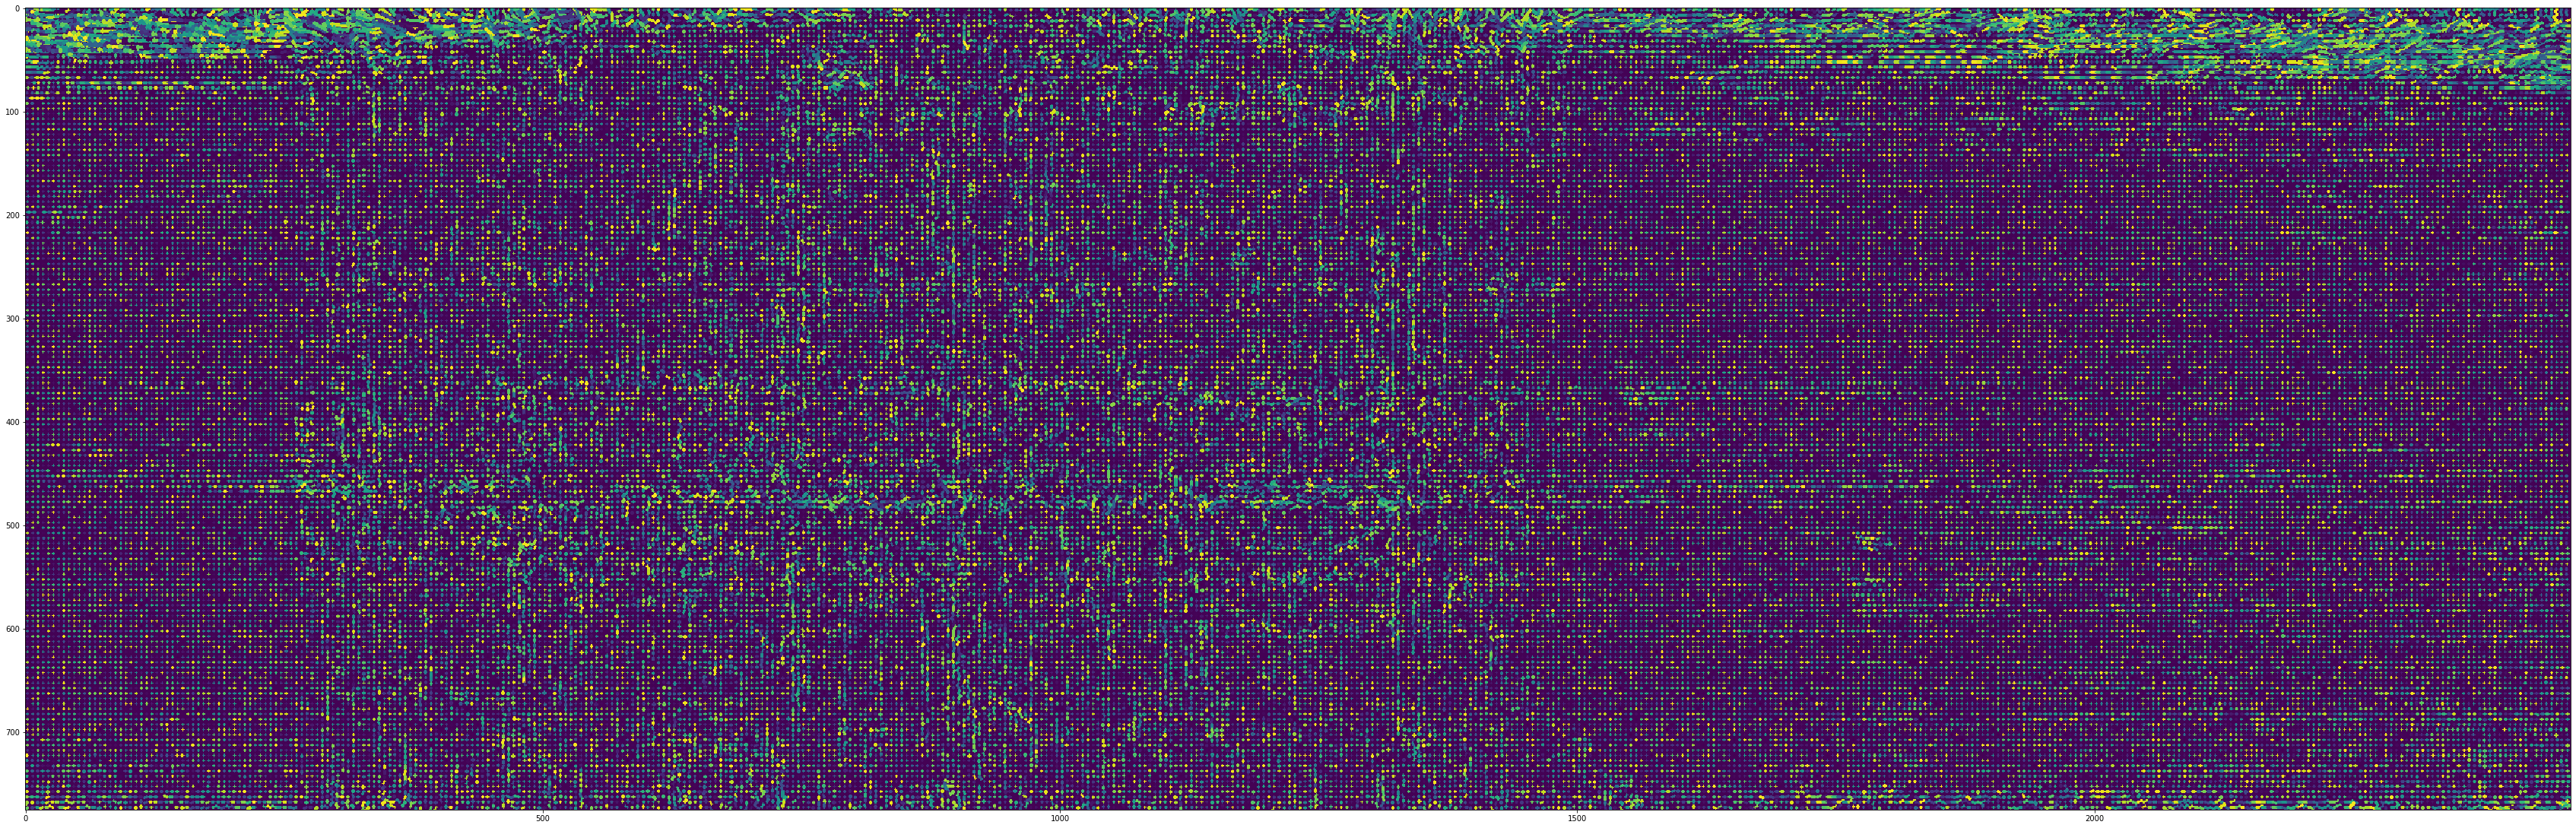

In [326]:
plt.figure(figsize=(60, 20))
plt.imshow(draw_flow(left, flow, step=5))
plt.show()

In [312]:
np.array([x, y]).swapaxes(0, 2).swapaxes(0, 1)

(775, 2461, 2)